# Kinect 2D to 3D

In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

import mlflow
mlflow.set_tracking_uri('http://35.228.45.76:5000')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='./mlflow-312506-6387830e8324.json'

In [15]:
import warnings
warnings.simplefilter('ignore')

In [16]:
random_state = 47
np.random.seed(random_state)

In [17]:
datasetPath = '../../datasets/kinect_good_preprocessed_not_cut/'

X = None
y = pd.DataFrame()

train_test_ratio = 0.8

## 1. Data Preparation

Loading files and separating between (X,Y) and Z.

In [18]:
import re

for file in os.listdir(datasetPath):
    if file.endswith('.csv'):
        try:
            dataset = pd.read_csv(datasetPath + file)
            dataset.drop(columns=['FrameNo'], inplace=True)

            # Separate (X,Y) and Z
            z = []
            temp = pd.DataFrame()
            for c in dataset.columns:
                if re.search("^.*_z$", c):
                    temp[c] = dataset[c]
                    dataset.drop(columns=[c], inplace=True)
            
            if X is None:
                X = dataset
            else:
                X = pd.concat((X, dataset), ignore_index=True)

            if y is None:
                y = temp
            else: 
                y = pd.concat((y, temp), ignore_index=True)

        except IOError as e:
            print('Error in reading file: ', e)

print(X.shape)
print(y.shape)

(38027, 26)
(38027, 13)


### Training and test split

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=train_test_ratio, random_state=random_state)

input_dim = X_train.shape[1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30421, 26)
(30421, 13)
(7606, 26)
(7606, 13)


### Scaling

In [20]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)

## 2. DL Model

### Early stopping

In [21]:
from keras.callbacks import EarlyStopping

# Early stopping parameters
monitor = 'val_loss'
verbose = 1
patience = 20
mode = 'min'
restore_best_weights = True

early_stopping = EarlyStopping(
    monitor=monitor, 
    verbose=verbose,
    patience=patience,
    mode=mode,
    restore_best_weights=restore_best_weights)

### Layer Factory

In [22]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten

def layerFactory(type, nodes, activation):
    if type == 'Dense':
        if not activation:
            return Dense(units=nodes)
        else:
            return Dense(units=nodes, activation=activation)
    if type == 'Conv1D':
        if not activation:
            return Conv1D(units=nodes)
        else:
            return Conv1D(units=nodes, activation=activation)
    if type == 'MaxPooling1D':
        if not activation:
            return MaxPooling1D(units=nodes)
        else:
            return MaxPooling1D(units=nodes, activation=activation)
    if type == 'Dropout':
        if not activation:
            return Dropout(units=nodes)
        else:
            return Dropout(units=nodes, activation=activation)
    if type == 'Flatten':
        if not activation:
            return Flatten(units=nodes)
        else:
            return Flatten(units=nodes, activation=activation)
    
    # otherwise return dense as default
    return Dense(units=nodes, activation=activation)

### Model Architecture

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

def create_model(optimizer):
    model = Sequential([
        InputLayer(input_shape=(input_dim))
    ])

    for layer in layers:
        model.add(layerFactory(layer['type'], layer['nodes'], layer['activation']))

    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate.assign(learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print(model.summary())
    return model

## 3. Evaluation Metrics

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

def eval_metrics(actual, pred):
    mse = mean_squared_error(actual, pred)
    msa = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    variance = explained_variance_score(actual, pred)
    return mse, msa, r2, variance

## 4. MLFlow Experimentation

In [25]:
with mlflow.start_run():
    # Model parameters
    units = 64
    activation = 'relu'
    output_layer = ''
    output_size = 13
    learning_rate = 0.001
    optimizer = 'Adam'
    loss = 'mse'
    metrics = ['mae']
    epochs = 500
    batch_size = 16
    layers = [ 
        { 'type': 'Dense', 'nodes':64, 'activation': 'relu' },
        { 'type': 'Dense', 'nodes':64, 'activation': 'relu' },
        { 'type': 'Dense', 'nodes':13, 'activation': ''}
    ]

    model = create_model(optimizer=optimizer)
    history = model.fit(x=X_train, y=y_train, validation_split=0.2, shuffle=True, epochs=epochs, verbose=1, batch_size=batch_size, callbacks=[early_stopping])

    predictions = model.predict(X_test, verbose=1)
    # Invert transform on predictions
    predictions = y_scaler.inverse_transform(predictions)
    (mse, msa, r2, variance) = eval_metrics(y_test, predictions)

    # Print metrics
    print("\nKinect2D_to_3D model (optimizer={}, learning_rate={}):".format(optimizer, learning_rate))
    print('MSE: ', mse)
    print('MSA: ', msa)
    print('R-Squared: ', r2)
    print('Explained Variance Score: ', variance)

    # Log parameter, metrics, and model to MLflow
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("learning rate", learning_rate)
    mlflow.log_param("batch size", batch_size)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("msa", msa)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("variance", variance)

    mlflow.keras.log_model(model, "gs://mlflow-atlas/mlflow_artifacts/0")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1728      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 13)                845       
Total params: 6,733
Trainable params: 6,733
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
1521/1521 [==============================] - 2s 794us/step - loss: 0.2994 - mae: 0.3588 - val_loss: 0.1236 - val_mae: 0.2466
Epoch 2/500
1521/1521 [==============================] - 1s 745us/step - loss: 0.1140 - mae: 0.2354 - val_loss: 0.0927 - val_mae: 0.2158
Epoch 3/500
1521/1521 [==============================] - 1s 691us/step - loss: 0.0847 - mae: 0.2071 - val

### Plot training and validation MAE & loss per epoch

In [26]:
training_history = pd.DataFrame(history.history)
training_history['epochs'] = range(len(training_history['mae']))

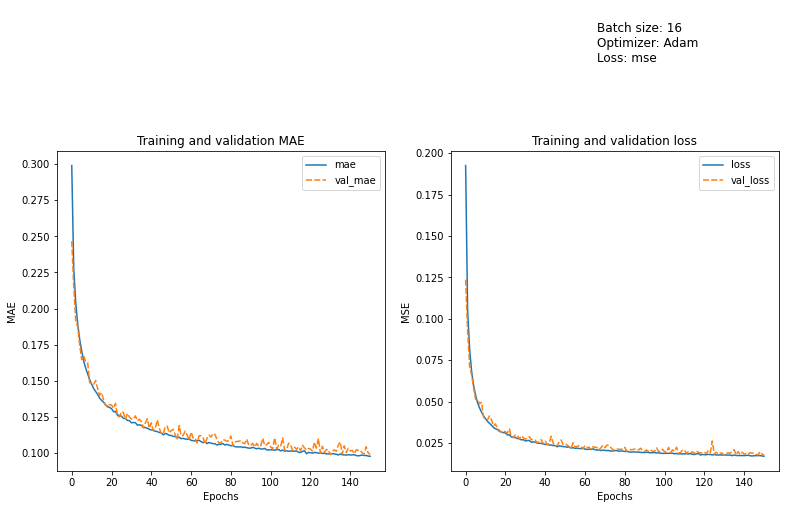

In [27]:
plots = [
           {'cols':['mae', 'val_mae'], 'title':'Training and validation MAE', 'yLabel':'MAE'},
           {'cols':['loss', 'val_loss'], 'title':'Training and validation loss', 'yLabel':'MSE'},
]

fig = plt.figure(figsize=(20,20))
fig_no = 331
title = '\nBatch size: {}\nOptimizer: {}\nLoss: {}'.format(batch_size,optimizer, loss)
fig.suptitle(title, fontsize="large", horizontalalignment='left', verticalalignment='top')

for i in range(len(plots)):
    ax = fig.add_subplot(str(fig_no))
    sns.lineplot(data=training_history[plots[i]['cols']], ax=ax)
    plt.title(plots[i]['title'])
    plt.xlabel('Epochs')
    plt.ylabel(plots[i]['yLabel'])
    fig_no += 1

plt.show()